In [6]:
%%bash
#get list of available kernels
jupyter kernelspec list

Available kernels:
  ir         /home/ec2-user/.local/share/jupyter/kernels/ir
  python3    /home/ec2-user/anaconda3/envs/python3/share/jupyter/kernels/python3


[ListKernelSpecs] WARNING | Config option `kernel_spec_manager_class` not recognized by `ListKernelSpecs`.


In [ ]:
%%bash
#remove sentinel_venv kernel
jupyter kernelspec uninstall sentinel_venv -y
#conda env remove -name sentinel_venv

### Bash shell script within Jupyter cell, to be run after instance starts as venv disappears after instance stops
### Select sentinel_venv kernel upon reopening of this Jupyter Notebook

In [ ]:
%%bash
#or %%sh
conda create --name sentinel_venv --yes
source activate sentinel_venv
conda install -c conda-forge gdal -y
conda install -c conda-forge cartopy -y
conda install -c conda-forge rasterio -y
conda install -c conda-forge netcdf4 -y
pip install ipykernel
pip install boto3
pip install pandas
pip install numpy
python -m ipykernel install --user --name sentinel_venv --display-name "sentinel_venv"
echo 'RESTART JUPYTER NOTEBOOK NOW'

In [2]:
import boto3

bucket = 'meeo-s5p'
subfolder = 'COGT/OFFL/L2__CO____/2022/01/01/'

conn = boto3.client('s3')
contents = conn.list_objects(Bucket=bucket, Prefix=subfolder)['Contents']

keys = []
for f in contents:
    if f['Key'].endswith('.tif') == True:
        if 'column' in f['Key']:
            keys.append(f['Key'])
            
keys[0]

'COGT/OFFL/L2__CO____/2022/01/01/S5P_OFFL_L2__CO_____20220101T004639_20220101T022809_21858_02_020301_20220102T143525_PRODUCT_carbonmonoxide_total_column_4326.tif'

In [3]:
len(keys)

14

In [11]:
keys[6:8]

['COGT/OFFL/L2__CO____/2022/01/01/S5P_OFFL_L2__CO_____20220101T105540_20220101T123710_21864_02_020301_20220103T004623_PRODUCT_carbonmonoxide_total_column_4326.tif',
 'COGT/OFFL/L2__CO____/2022/01/01/S5P_OFFL_L2__CO_____20220101T123710_20220101T141839_21865_02_020301_20220103T022556_PRODUCT_carbonmonoxide_total_column_4326.tif']

#remove 'COGT/' from beginning each file key in keys var
for i in range(len(keys)):
    keys[i] = keys[i][5:]
    
keys[0:3]

### LOOP EXTRACTION

/tmp/ipykernel_20343/3974215918.py:34: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gist_ncar").copy()
  color.set_bad('white')


GEOTIFF IMAGE EXTRACTION COMPLETE


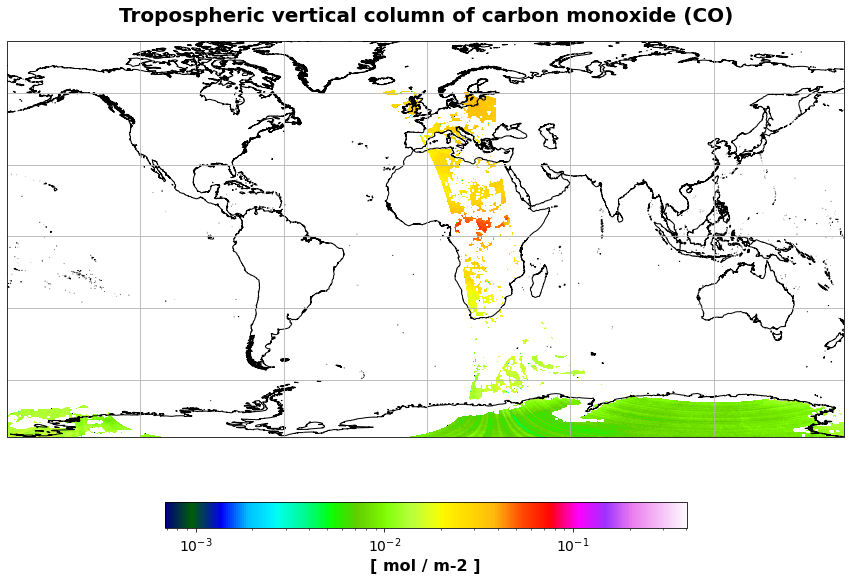

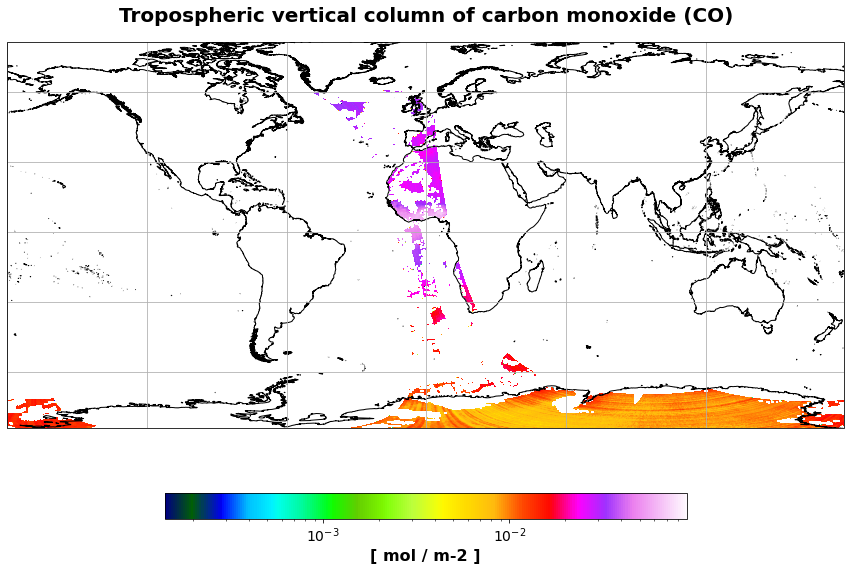

In [16]:
import cartopy.crs as ccrs
import rasterio

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

from rasterio.plot import show

count = 0

for i in keys[6:8]:
    bucket='meeo-s5p'
    file_key = i

    s3uri = 's3://{}/{}'.format(bucket, file_key)
    raster = rasterio.open(s3uri)

    NoData = raster.nodatavals
    unit = '[ mol / m-2 ]'
    long_name = 'Tropospheric vertical column of carbon monoxide (CO)'
    bbox = raster.bounds
    #BoundingBox(left=-175.67385864257812, bottom=-83.9475067138672, right=174.5361413574219, top=81.60249328613281)
    extent=[bbox[0],bbox[2],bbox[1],bbox[3]]
    #london filter
    #extent=[51.239405, -0.625211, 51.737184, 0.328289]

    fig=plt.figure(figsize=(15, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.gridlines()
    ax.set_title(long_name, fontsize=20, pad=20.0, fontweight = 'bold')
    color = cm.gist_ncar
    color.set_bad('white')
    img = plt.imshow(raster.read(1), cmap = color,extent = extent,norm=LogNorm(),transform=ccrs.PlateCarree())
    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(unit, fontsize=16, fontweight = 'bold')
    cbar.ax.tick_params(labelsize=14)
    
    count +=1
    img_pathname = 'geotiff_images/carbonmonoxide_total_column' + str(count) + '.png'
    plt.savefig(img_pathname)
    
    #plt.show()

print('GEOTIFF IMAGE EXTRACTION COMPLETE')

So above is the meta data assciated with this file. The rasterio raster object contains all the meta data that we need and we will use it below.

### MANUAL EXTRACTION

In [13]:
import cartopy.crs as ccrs
import rasterio

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

from rasterio.plot import show

bucket='meeo-s5p/COGT'
file_key = 'OFFL/L2__CO____/2022/01/01/S5P_OFFL_L2__CO_____20220101T105540_20220101T123710_21864_02_020301_20220103T004623_PRODUCT_carbonmonoxide_total_column_4326.tif'

s3uri = 's3://{}/{}'.format(bucket, file_key)

# For convenience I have stored the COG file in the same directory as this notebook.
# Note you may have given the file a different name.
#fp = r"S5P_OFFL_L2__CO_____20220101T004639_20220101T022809_21858_02_020301_20220102T143525_PRODUCT_carbonmonoxide_total_column_4326.tif"
fp = s3uri

raster = rasterio.open(fp)

# This will print out the meta data associated with this file.
print(raster.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 10006, 'height': 4730, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.035, 0.0, -175.67385864257812,
       0.0, -0.035, 81.60249328613281)}


So above is the meta data assciated with this file. The rasterio raster object contains all the meta data that we need and we will use it below.

In [14]:
# Tell the visualizer what is a 'no data' flag, in this case, 
# from looking at the meta data above we see that it is -9999.0.
NoData = raster.nodatavals

# Data visualization units.
unit = '[ mol / m-2 ]'

# This is this title of the graph that will appear below.
long_name = 'Tropospheric vertical column of carbon monoxide (CO)'

# We need to know the geographical extent of the data, this is contained in the raster object.
bbox = raster.bounds
extent=[bbox[0],bbox[2],bbox[1],bbox[3]]
print(bbox)
print(extent)

BoundingBox(left=-175.67385864257812, bottom=-83.9475067138672, right=174.5361413574219, top=81.60249328613281)
[-175.67385864257812, 174.5361413574219, -83.9475067138672, 81.60249328613281]


/tmp/ipykernel_20343/1646303408.py:15: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gist_ncar").copy()
  color.set_bad('white')


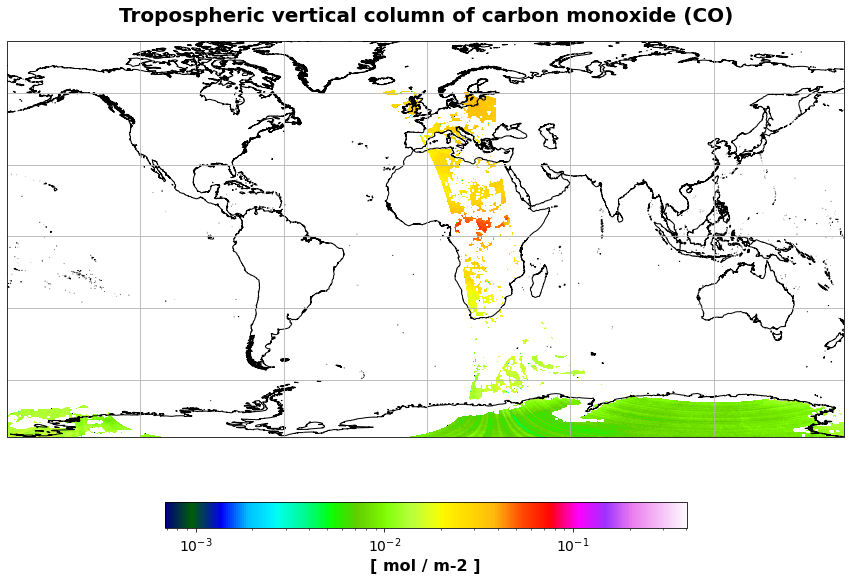

In [10]:
# Here we set up the parameters needed to display the geographical data correctly.
fig=plt.figure(figsize=(15, 12))

# Here we set up a simple Plate Carree geographical projection.  This  handled by cartopy library.
ax = plt.axes(projection=ccrs.PlateCarree())

# The latest coastline data gets downloaded here, there may be a delay the first time you run this notebook.
ax.coastlines(resolution='10m')
ax.gridlines()
ax.set_title(long_name, fontsize=20, pad=20.0, fontweight = 'bold')

# Here we set the colour map for matplotlib. e.g. 'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'jet'
color = cm.gist_ncar

color.set_bad('white')

# In the norm setting below we normalise the data so that it scales between 0 to 1
img = plt.imshow(raster.read(1), cmap = color,extent = extent,norm=LogNorm(),transform=ccrs.PlateCarree())

cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
cbar.set_label(unit, fontsize=16, fontweight = 'bold')
cbar.ax.tick_params(labelsize=14)

plt.show()